In [208]:
import pandas as pd
import uproot
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
torch.autograd.set_detect_anomaly(True)
import awkward as ak

In [3]:
df = pd.read_csv('data/concatenated.csv')

In [76]:
df = df.dropna()

In [77]:
df.head()

,Unnamed: 0,event,run,met_pt,met_phi,met_E,met_Px,met_Py,met_Pz,is_SR,...,total_weight,ls,considered_jets,MEM_weight,MEM_weight_err,MEM_time,MEM_status,del_l2_phi,del_j1_phi,del_j2_phi
0,0,45329285.0,1.0,38.984746,0.305608,38.984745,37.178356,11.729450,0.0,1.0,...,0.873387,229090.0,0,3.918931,5.435769e-23,8.468740,0.0,-5.074219,-3.013184,-0.196777
1,1,27289755.0,1.0,50.834523,-2.597592,50.834522,-43.496319,-26.310055,0.0,1.0,...,0.751147,137920.0,0,3.947367,2.362927e-23,5.423543,0.0,-0.043945,3.330322,1.355286
2,2,40361426.0,1.0,25.922679,0.368697,25.922680,24.180618,9.342539,0.0,1.0,...,0.765145,203983.0,0,3.999784,1.917346e-24,2.085152,0.0,-1.685802,-1.770477,-4.159668
3,3,14023019.0,1.0,37.794698,-2.372525,37.794697,-27.157721,-26.284925,0.0,1.0,...,0.785262,70871.0,0,4.044958,7.018110e-26,3.300586,0.0,-0.428711,3.733398,2.099243
4,4,22080379.0,1.0,31.210966,1.643532,31.210966,-2.268147,31.128443,0.0,1.0,...,0.884972,111593.0,0,3.991430,1.125046e-24,11.022686,0.0,-0.425293,2.609619,2.234009


In [501]:
tree = uproot.open("data/DYJetsToLL_M-50.root")
tree.keys()

['ElEl_Resolved1Btag_nominal;1',
 'ElEl_Resolved2Btag_nominal;1',
 'MuMu_Resolved1Btag_nominal;1',
 'MuMu_Resolved2Btag_nominal;1',
 'ElMu_Resolved1Btag_nominal;1',
 'ElMu_Resolved2Btag_nominal;1']

In [ ]:
store = {}
for key in tree.keys():
    store[key] = tree[key].array()

In [506]:
tree = uproot.open("data/DYJetsToLL_M-10to50.root")

In [507]:
branches = ['ElEl_Resolved2Btag_nominal;1','MuMu_Resolved1Btag_nominal;1','MuMu_Resolved2Btag_nominal;1','ElMu_Resolved1Btag_nominal;1','ElMu_Resolved2Btag_nominal;1']
for branch in branches:
    for key in tree[branch].keys():
        store[key] = ak.concatenate([store[key], (tree[branch][key].array())])

In [508]:
df = pd.DataFrame(store)

In [510]:
df = df.dropna()

In [511]:
df = df.query('MEM_status == 0') 

In [512]:
df.replace({-9999.000000: 0}, inplace=True)

In [513]:
def get_positive_phi(row):
    if row['l1_charge'] > 0:
        return row['l1_phi']
    elif row['l2_charge'] > 0:
        return row['l2_phi']
    else:
        return None

In [514]:
df['positive_phi'] = df.apply(get_positive_phi, axis=1)

In [515]:
for particle in ["l1", "l2", "j1","j2", "j3", "j4"]:
    df[f'del_{particle}_phi'] = (df[f'{particle}_phi'] -  df['positive_phi'])

In [517]:
df['MEM_weight'] = (-np.log10(df['MEM_weight']))

<AxesSubplot:>

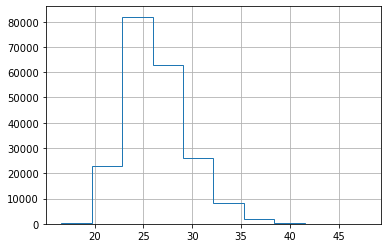

In [518]:
df['MEM_weight'].hist( histtype='step')

In [519]:


X = df.loc[:, ['l1_pt', 'l2_pt','j1_pt','j2_pt','j3_pt','j4_pt',
               'l1_eta', 'l2_eta', 'j1_eta', 'j2_eta', 'j3_eta', 'j4_eta',
               'del_l1_phi', 'del_l2_phi', 'del_j1_phi', 'del_j2_phi', 'del_j3_phi', 'del_j4_phi']].values.astype(np.float32)





In [520]:
y = df['MEM_weight'].values.astype(np.float32)

In [521]:
scaler_x, scaler_y = StandardScaler(), StandardScaler()

In [522]:
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1,1))

In [534]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

In [535]:
np.isnan(y_train).any()

False

In [536]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn.functional as F

class ValidationLossCallback(pl.Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        validation_loss = trainer.callback_metrics.get('val_loss')
        

class GaussianLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true, sigma):
        squared_diff = torch.pow(y_pred - y_true, 2)

        loss = squared_diff / torch.pow(sigma, 2)

        return loss.mean()
        

class RegressionModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, hidden_dim_2, hidden_dim_3,hidden_dim_4, hidden_dim_5, output_dim):
        super(RegressionModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, hidden_dim_4)
        self.fc5 = nn.Linear(hidden_dim_4, hidden_dim_5)
        self.fc6 = nn.Linear(hidden_dim_5, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x)) 
        x = torch.relu(self.fc3(x)) 
        x = torch.relu(self.fc4(x)) 
        x = torch.relu(self.fc5(x)) 
        return self.fc6(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        #criterion = GaussianLoss()
        #loss = criterion(y_pred, y_true, sigma)
        loss = nn.MSELoss()
        loss = loss(y_pred, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        val_loss = nn.MSELoss()(y_pred, y)
        self.log('val_loss', val_loss, prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [ ]:
train_size = int(0.8 * y_train.shape[0])
train_dataset = TensorDataset(torch.tensor(X_train[:train_size]), torch.tensor(y_train[:train_size]))
val_dataset = TensorDataset(torch.tensor(X_train[train_size:]), torch.tensor(y_train[train_size:]))

class RegressionDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, batch_size=64):
        super(RegressionDataModule, self).__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=16)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=16)


data_module = RegressionDataModule(train_dataset, val_dataset)


model = RegressionModel(input_dim=X.shape[1], hidden_dim=128, hidden_dim_2=64, hidden_dim_3=32, hidden_dim_4=16, hidden_dim_5=4, output_dim=1)


early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')


trainer = pl.Trainer(max_epochs=100, gpus=1 if torch.cuda.is_available() else 0, callbacks=[ValidationLossCallback(), early_stopping_callback])


trainer.fit(model, data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 1.2 K 
1 | fc2  | Linear | 8.3 K 
2 | fc3  | Linear | 4.1 K 
3 | fc4  | Linear | 528   
4 | fc5  | Linear | 68    
5 | fc6  | Linear | 5     
--------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [530]:
input_tensor = torch.tensor(X_test, dtype=torch.float32)

model.eval()

with torch.no_grad():  
    predictions = model(input_tensor)

predictions = predictions.numpy()

In [531]:
counts_y, bins_y = np.histogram(scaler_y.inverse_transform(y_test), bins=100)
counts_pred, bins_pred = np.histogram(scaler_y.inverse_transform(predictions), bins=100)

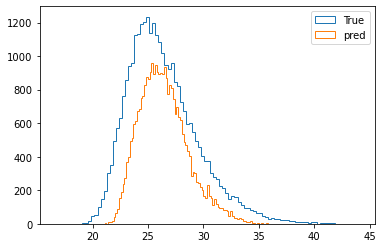

In [532]:
plt.hist(bins_y[:-1], bins_y, weights=counts_y, histtype='step', label='True')
plt.hist(bins_pred[:-1], bins_pred, weights=counts_pred, histtype='step', label='pred')
plt.legend()